# House Price Prediction - 04 - Linear Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [2]:
sns.set(rc={"figure.figsize":(16, 9)})

In [3]:
df_train = pd.read_csv("data/train.csv")

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### Drop ID column (no duplicates) 

In [6]:
df_train.drop(['Id'], axis=1, inplace=True)

#### Imputation 

In [7]:
values = {'Alley': 'No alley access', 'MiscFeature': 'None', 'PoolQC': 'No Pool',
          'Fence': 'No Fence', 'FireplaceQu': 'No Fireplace', 'LotFrontage': 'No Lotfrontage',
         'GarageYrBlt': ' No Garage', 'GarageCond': ' No Garage', 'GarageType': ' No Garage',
          'GarageFinish': ' No Garage', 'GarageQual': ' No Garage', 'BsmtQual': 'No Basement',
          'BsmtCond': 'No Basement', 'BsmtExposure': 'No Basement', 'BsmtFinType1': 'No Basement',
          'BsmtFinType2': 'No Basement', 'MasVnrType': 'None', 'MasVnrArea': 'None', }

df_train.fillna(value=values, inplace=True)
df_train.Electrical.fillna(df_train.Electrical.mode()[0], inplace=True)

In [8]:
df_train.isnull().sum().sum()

0

#### Outliers

From the documentation: "I would recommend removing any houses with more than 
4000 square feet from the data set (which eliminates these five unusual observations) 
before assigning it to students."

http://jse.amstat.org/v19n3/decock.pdf

In [9]:
df_train[df_train.GrLivArea > 4000][['GrLivArea', 'SalePrice']]

,GrLivArea,SalePrice
523,4676,184750
691,4316,755000
1182,4476,745000
1298,5642,160000


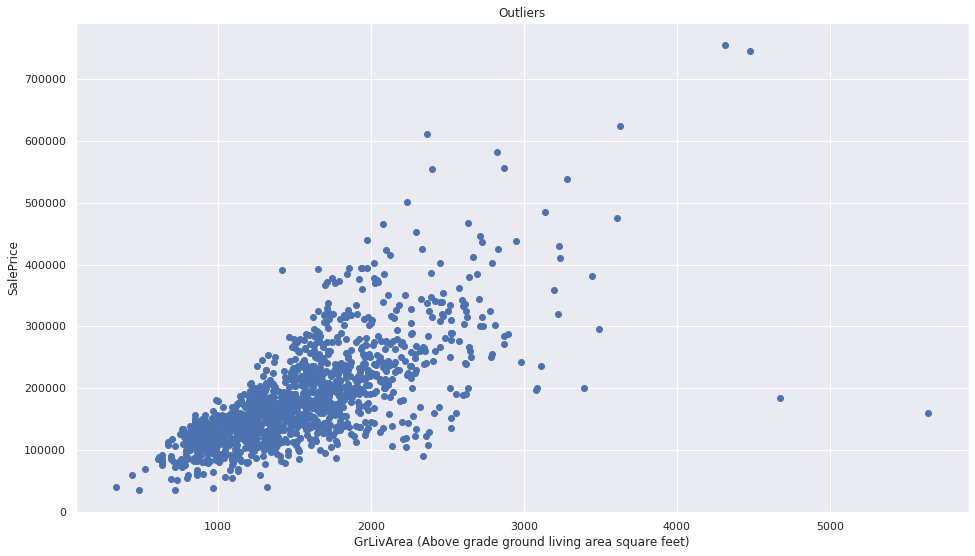

In [10]:
plt.scatter(df_train.GrLivArea, df_train.SalePrice)
plt.title("Outliers")
plt.xlabel('GrLivArea (Above grade ground living area square feet)')
plt.ylabel('SalePrice')
plt.savefig("plots/outliers.png", bbox_inches='tight')

In [11]:
df_train = df_train[df_train['GrLivArea'] < 4000]

#### Log-Transformation of the dependent variable 

In [12]:
df_train.SalePrice = np.log(df_train.SalePrice)

#### Converting `MSSubClass` and `MoSold` from numerical to categorical data

In [13]:
subclass_dict = {20: "1-STORY 1946 & NEWER ALL STYLES",
                 30: "1-STORY 1945 & OLDER",
                 40: "1-STORY W/FINISHED ATTIC ALL AGES",
                 45: "1-1/2 STORY - UNFINISHED ALL AGES",
                 50: "1-1/2 STORY FINISHED ALL AGES",
                 60: "2-STORY 1946 & NEWER",
                 70: "2-STORY 1945 & OLDER",
                 75: "2-1/2 STORY ALL AGES",
                 80: "SPLIT OR MULTI-LEVEL",
                 85: "SPLIT FOYER",
                 90: "DUPLEX - ALL STYLES AND AGES",
                 120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
                 150: "1-1/2 STORY PUD - ALL AGES",
                 160: "2-STORY PUD - 1946 & NEWER",
                 180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
                 190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"}
df_train.MSSubClass = df_train.MSSubClass.map(subclass_dict)
df_train.MoSold = df_train.MoSold.astype(str)

#### Converting categorical to ordinal data

In [14]:
df_train.replace({"Street": {"Grvl": 0, "Pave": 1}}, inplace=True)

#### Features most correlated to SalePrice 

In [15]:
df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.819240
GrLivArea,0.718844
GarageCars,0.680408
GarageArea,0.655211
TotalBsmtSF,0.641553
1stFlrSF,0.613742
FullBath,0.590919
YearBuilt,0.588977
YearRemodAdd,0.568986


#### Modelling 

In [16]:
# features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 
#            'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces']

features = df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False).index[1:]

In [17]:
def iterate_model_features(features):
    for feature in features:
        X_train, X_test, y_train, y_test = train_test_split(df_train[[feature]], df_train.SalePrice,
                                                        test_size = 0.25, random_state = 0)
        model_lr = LinearRegression()
        model_lr.fit(X_train, y_train)
        y_train_pred = model_lr.predict(X_train)
        y_test_pred = model_lr.predict(X_test)
        print(feature)
        print(f'mean squared error: %.0f'
          % mean_squared_error(y_test, y_test_pred), end='')
        print(' - Coefficient of determination: %.2f'
          % r2_score(y_test, y_test_pred), end='\n\n')
    
iterate_model_features(features=features)

OverallQual
mean squared error: 0 - Coefficient of determination: 0.71

GrLivArea
mean squared error: 0 - Coefficient of determination: 0.56

GarageCars
mean squared error: 0 - Coefficient of determination: 0.42

GarageArea
mean squared error: 0 - Coefficient of determination: 0.40

TotalBsmtSF
mean squared error: 0 - Coefficient of determination: 0.44

1stFlrSF
mean squared error: 0 - Coefficient of determination: 0.39

FullBath
mean squared error: 0 - Coefficient of determination: 0.34

YearBuilt
mean squared error: 0 - Coefficient of determination: 0.38

YearRemodAdd
mean squared error: 0 - Coefficient of determination: 0.34

TotRmsAbvGrd
mean squared error: 0 - Coefficient of determination: 0.31

Fireplaces
mean squared error: 0 - Coefficient of determination: 0.23

BsmtFinSF1
mean squared error: 0 - Coefficient of determination: 0.13

WoodDeckSF
mean squared error: 0 - Coefficient of determination: 0.13

OpenPorchSF
mean squared error: 0 - Coefficient of determination: 0.10

HalfB

In [27]:
# features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 
#            'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces']
features = df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False).index[1:]

def cumulative_model_features(features):
    for i in range(1, len(features)):
        features_cumulative = features[0:i]
        X_train, X_test, y_train, y_test = train_test_split(df_train[features_cumulative], df_train.SalePrice,
                                                        test_size = 0.25, random_state = 0)
        model_lr = LinearRegression()
        model_lr.fit(X_train, y_train)
        y_train_pred = model_lr.predict(X_train)
        y_test_pred = model_lr.predict(X_test)
        print(features_cumulative)
        print(f'mean squared error: %.5f'
          % mean_squared_error(y_test, y_test_pred), end='')
        print(' - Coefficient of determination: %.2f'
          % r2_score(y_test, y_test_pred), end='\n\n')
    
cumulative_model_features(features=features)

Index(['OverallQual'], dtype='object')
mean squared error: 0.04517 - Coefficient of determination: 0.71

Index(['OverallQual', 'GrLivArea'], dtype='object')
mean squared error: 0.03216 - Coefficient of determination: 0.80

Index(['OverallQual', 'GrLivArea', 'GarageCars'], dtype='object')
mean squared error: 0.02784 - Coefficient of determination: 0.82

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'], dtype='object')
mean squared error: 0.02737 - Coefficient of determination: 0.83

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'], dtype='object')
mean squared error: 0.02342 - Coefficient of determination: 0.85

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF'],
      dtype='object')
mean squared error: 0.02340 - Coefficient of determination: 0.85

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath'],
      dtype='object')
mean squared error: 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train.SalePrice, test_size = 0.25, random_state = 0)

In [20]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train: (1092, 32)
X_test: (364, 32)
y_train: (1092,)
y_test : (364,)


In [21]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [22]:
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

In [23]:
print('Coefficients: \n', model_lr.coef_)

Coefficients: 
 [ 6.79787026e-02  1.54142716e-04  2.94370721e-02  1.21357960e-04
  1.05069392e-04  1.09167791e-04  1.80706412e-02  3.02595297e-03
  1.01508223e-03  1.35721433e-02  3.38953718e-02  8.19782184e-05
  7.26069451e-05  2.63153752e-05  1.78241621e-02  8.67734398e-05
  3.11239341e-06  3.50614344e-02  1.95894415e-05 -1.40078420e-02
  3.10596252e-04  2.68271325e-01  2.79722902e-04  1.32658033e-04
  3.50173187e-06  7.18404200e-03 -4.35058846e-06 -6.02438335e-03
  5.37498209e-02 -4.17985153e-05 -8.27428770e-02  5.79290972e-05]


In [24]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred))

Mean squared error: 0.01


#### The coefficient of determination: 1 is perfect prediction

The coefficient of determination tells you what proportion of the variance in your predicted variables can be explained by the predictors.

If your determination coefficient is 1, your predictors perfectly predict your dependent variables. If it is 0, your predictors tell you nothing about the value of the dependent variable.

taken from: https://programmathically.com/the-coefficient-of-determination-and-linear-regression-assumptions/

In [25]:
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_test_pred))

Coefficient of determination: 0.91


#### Prediction Plot

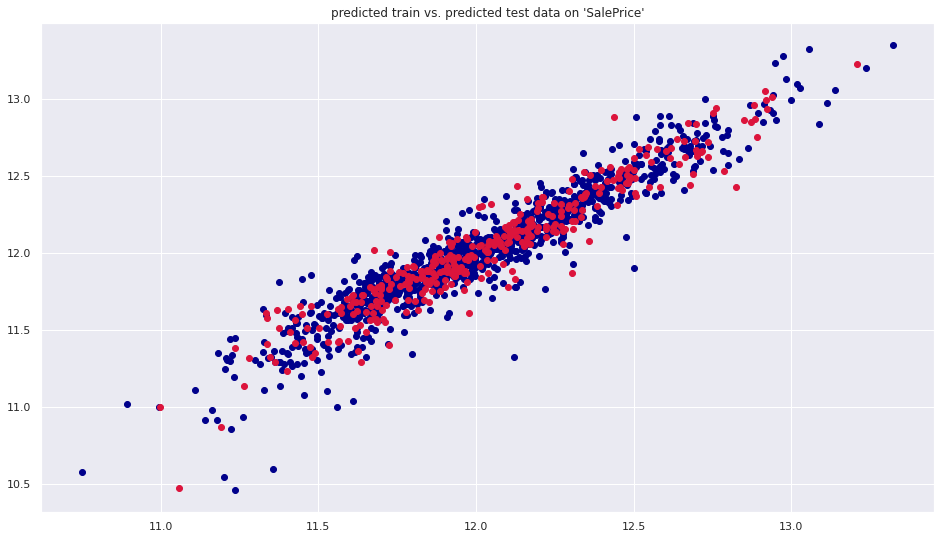

In [26]:
plt.scatter(y_train_pred, y_train, color="darkblue")
plt.scatter(y_test_pred, y_test, color="crimson")
plt.title("predicted train vs. predicted test data on 'SalePrice'")
plt.savefig("plots/prediction_plot.png", bbox_inches='tight')